In [1]:
import numpy as np
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss, MSELoss
from pennylane import NesterovMomentumOptimizer
from thesis.qcnn import QCNN

dims = (16, 16), (28, 28), (32, 32)
num_trials = 1

2023-05-18 00:00:46,035: (model) Number of Parameters: 54
2023-05-18 00:01:39,206: (model) Accuracy: 99.527%


((<Figure size 640x480 with 1 Axes>, <Figure size 1100x900 with 1 Axes>),
 (<Figure size 640x480 with 1 Axes>, <Figure size 1100x900 with 1 Axes>))

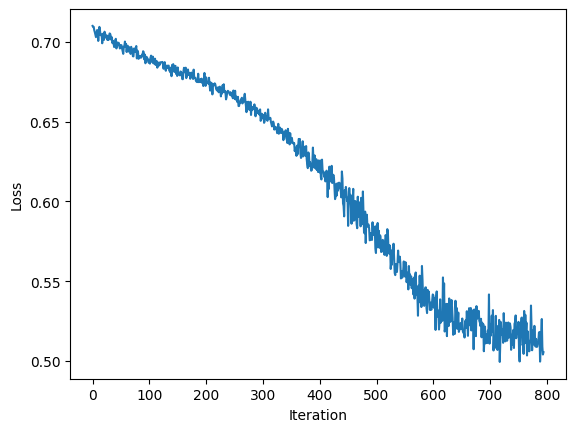

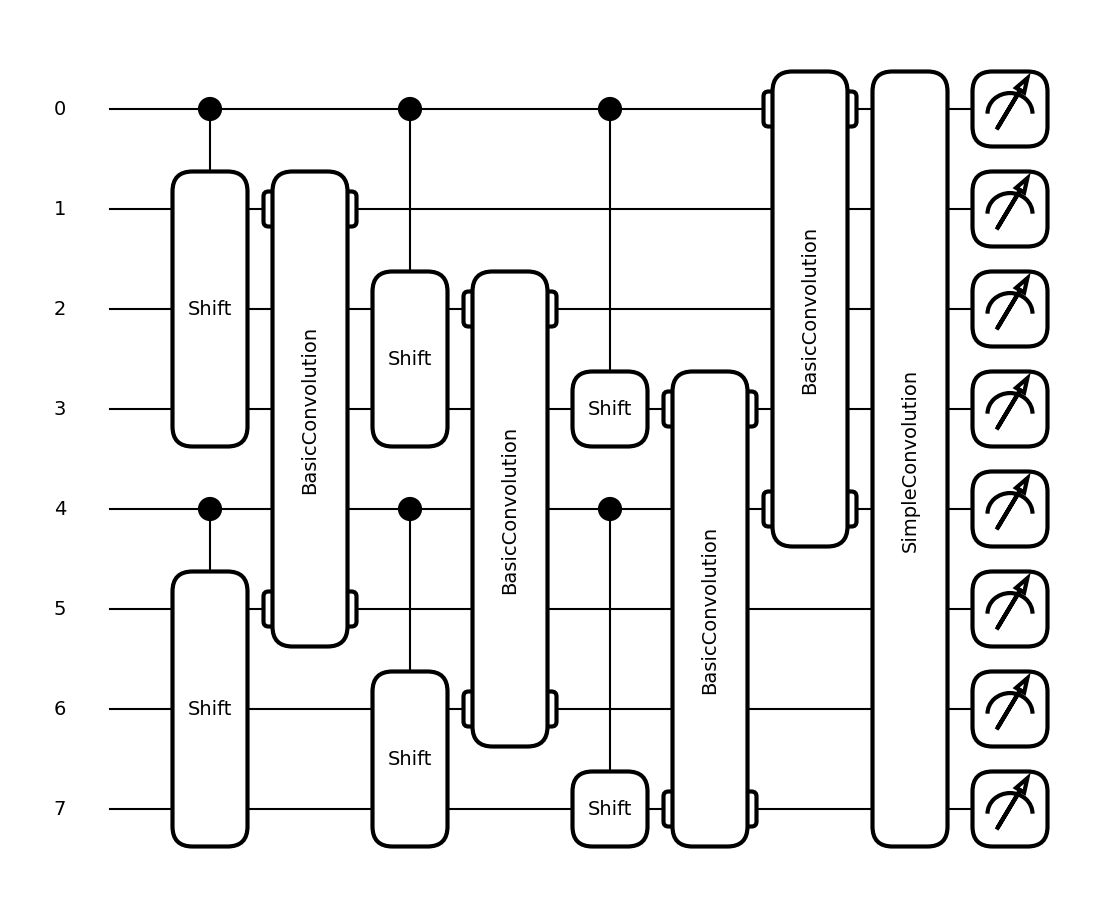

In [2]:
from thesis.quantum.operation.ansatz import ConvolutionAnsatz as A
from thesis.ml.data import Data
from thesis.ml.optimize import Optimizer
from thesis.ml.data import image_transform

dims = (16, 16)

data = Data(MNIST, image_transform(dims), None, classes=[0, 1], batch_size=(80, 1000))
# optimizer = Optimizer(SGD, lr=0.01, momentum=0.9, nesterov=True)
optimizer = Optimizer(Adam)
qcnn = QCNN.with_logging(data, optimizer, CrossEntropyLoss(), epoch=5)

for _ in range(num_trials):
    accuracy = qcnn(A, dims)
    
qcnn.draw()